In [1]:
if "descended" not in locals():
    descended = 1
    %cd ".."
    
import utils

import os
import numpy as np
import matplotlib.pyplot as plt
import pickle

/Users/Yke/Desktop/AI/Thesis/ESA/transit-detection-rnn


In [2]:
import utils

import os
import numpy as np
import matplotlib.pyplot as plt
import torch

from detection import rnn_detection as rnn_det
from detection import bls_detection as bls_det
from simulations import lightcurve_simulation as lcsim
import visualize as vis

from dataloading import loading as dl

from tqdm import tqdm
from scipy.ndimage import gaussian_filter1d

from wotan import flatten

In [3]:
# fnames = [fnm for fnm in os.listdir("data/eval/sim/singleplanet") if not fnm.startswith(".")]

# window_lengths = [0.25, 0.5, 1.0]  # days

# pbar = tqdm(fnames)
# for fname in pbar:
#     try:
#         bls_detections = {}
#         batch = dl.load_data("data/eval/sim/singleplanet/"+fname)
#         if batch is None:
#             continue
#         time = np.arange(len(batch["flux"][0]))*utils.min2day(2)
#         for i in range(len(batch["flux"])):
#             sampleid = int(batch["sampleid"][i])
#             bls_detections[sampleid] = {}
#             for wl in window_lengths:
#                 flat = flatten(time, batch["flux"][i], method="median", window_length=wl)
#                 detected = bls_det.algorithm(time, flat, num_iters=3)
#                 bls_detections[sampleid][wl] = detected
#         with open("results/bls_singles/"+fname, "wb") as f:
#             pickle.dump(bls_detections, f)
            
#     except:
#         pbar.close()
#         raise

In [4]:
# detections = {}
# for fnm in [fnm for fnm in os.listdir("results/bls_singles") if not fname.startswith(".")]:
#     with open("results/bls_singles/"+fnm, "rb") as f:
#         bls_det_batch = pickle.load(f)
#         detections = {**detections, **bls_det_batch}
# with open("results/bls_single_detections.pkl", "wb") as f:
#     pickle.dump(detections, f)

In [5]:
# rnn_ = torch.load("models/bigru1_w4sqrt_sim.pt")

In [6]:
# mean, std = -0.10192371859533564, 2.6337997430623323  # obtained from training set
# fnames = [fnm for fnm in os.listdir("data/eval/sim/monotransit") if not fnm.startswith(".")]

# rnn_.to("cpu")


# pbar = tqdm(fnames)
# for fname in pbar:
#     try:
#         rnn_detections = {}
#         batch = dl.load_data("data/eval/sim/singleplanet/"+fname)
#         if batch is None:
#             continue
#         sigma = np.array([batch["meta"][i]["sigma"] for i in batch["sampleid"]])
#         flux_ = ((batch["flux"]-1) / sigma[:,None] - mean) / std
  
#         flux_in = flux_.reshape(-1,flux_.shape[-1])
#         pts_ = np.zeros_like(flux_in)

#         step = 50
#         for i in range(step, len(flux_in)+1, step):
#             pts_[i-step:i] = rnn_det.get_pts(rnn_, flux_in[i-step:i], additional=False)
#             rnn_.to("cpu")

#         for i, sampleid in enumerate(batch["sampleid"]):
#             detected1 = rnn_det.algorithm1(pts_[i].copy(), num_iters=3, min_transits=3, p_min=2, p_max=None, step_mult=2, 
#                smooth=True, peak_frac=2, show_steps=False)
            
#             detected2 = rnn_det.algorithm2(pts_[i], None, num_iters=3, smooth=True, p_min=2)

#             rnn_detections[sampleid] = {"rnn1":detected1,
#                                         "rnn2":detected2}
#         with open("results/rnn_singles/"+fname, "wb") as f:
#             pickle.dump(rnn_detections, f)                       

#     except:
#         pbar.close()
#         raise

In [7]:
# detections = {}
# for fnm in [fnm for fnm in os.listdir("results/rnn_singles") if not fname.startswith(".")]:
#     with open("results/rnn_singles/"+fnm, "rb") as f:
#         rnn_det_batch = pickle.load(f)
#         detections = {**detections, **rnn_det_batch}
# with open("results/rnn_single_detections.pkl", "wb") as f:
#     pickle.dump(detections, f)

## Results

In [66]:
with open("results/bls_single_detections.pkl", "rb") as f:
    bls_detections = pickle.load(f)
    
best_only = False
if best_only:
    for i in bls_detections:
        for mname in bls_detections[i]:
            if len(list(bls_detections[i][mname].keys())):
                mx = np.max(list(bls_detections[i][mname].keys()))
                bls_detections[i][mname] = {mx:bls_detections[i][mname][mx]}

In [67]:
meta = {}
fnames = [fnm for fnm in os.listdir("data/eval/sim/singleplanet") if not fnm.startswith(".")]
for fname in fnames:
    batch = dl.load_data("data/eval/sim/singleplanet/"+fname)
    if batch is None:
        continue
    meta = {**meta, **batch["meta"]}

In [98]:
def correct_detection(params, detection, dur_factor=1, per_frac=0.01):
    # assumes sample (params) contains single planet 
    if params["planets"] == {}:
        print("sample contains no planets")
        raise Exception
    t0_true = params["planets"][0]["pl_t0"]
    dur_true = params["planets"][0]["pl_duration"]
    per_true = params["planets"][0]["pl_period"]
    t0_correct = (detection["t0"] > (t0_true - 0.5*dur_factor*dur_true)) and \
                 (detection["t0"] < (t0_true + 0.5**dur_factor*dur_true))
    per_correct = (1-per_frac)*per_true < detection["period"] and detection["period"] < (1+per_frac)*per_true
    correct = (t0_correct and per_correct)
    return correct

def get_fpr(dic):
    return dic["fp"] / (dic["fp"] + dic["tn"]) 
    
def get_tpr(dic):
    # recall
    return dic["tp"] / (dic["tp"] + dic["fn"]) 

def get_precion(dic):
    return dic["tp"] / (dic["tp"] + dic["fp"]) 

In [69]:
thresholds = np.linspace(0,20,100)
snames = ["tp", "fp", "fn", "tn"]
mnames = [0.25, 0.5, 1.0]

bls6h = {sname:[] for sname in snames}
bls12h = {sname:[] for sname in snames}
bls24h = {sname:[] for sname in snames}

pbar = tqdm(thresholds)
for thr in pbar:  
    try:
        for dic, mname in zip([bls6h, bls12h, bls24h], mnames):
            tp = fp = tn = fn = 0
            for i in meta:
                for score, det in bls_detections[i][mname].items():
                    if score >= thr:
                        if len(meta[i]["planets"]) > 0 and correct_detection(meta[i], det):
                            tp += 1
                        else:  # no planets in lc or false detection
                            fp += 1
                    else: # score < thr
                        if len(meta[i]["planets"]) > 0 and correct_detection(meta[i], det):
                            fn += 1 # !! = positives - tp
                        else:
                            tn += 1 # !! actually all detections (=inf) < threshold
                        
            if mname == 0.25:
                bls6h["tp"].append(tp), bls6h["fp"].append(fp)
                bls6h["tn"].append(tn), bls6h["fn"].append(fn)

            elif mname == 0.5:
                bls12h["tp"].append(tp), bls12h["fp"].append(fp)
                bls12h["tn"].append(tn), bls12h["fn"].append(fn)

            elif mname == 1.:
                bls24h["tp"].append(tp), bls24h["fp"].append(fp)
                bls24h["tn"].append(tn), bls24h["fn"].append(fn)
    except:
        pbar.close()
        raise

100%|██████████| 100/100 [00:09<00:00, 10.56it/s]


In [70]:
for sname in snames:
    bls6h[sname] = np.array(bls6h[sname])
    bls12h[sname] = np.array(bls12h[sname])
    bls24h[sname] = np.array(bls24h[sname])

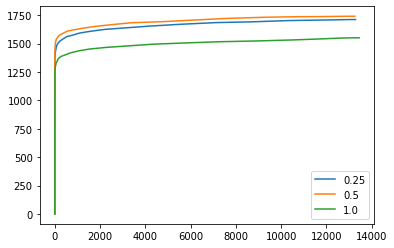

In [71]:
mnames = [0.25, 0.5, 1.0]
for dic, mname in zip([bls6h, bls12h, bls24h], mnames):
#     plt.plot(get_fpr(dic), get_tpr(dic), label=mname)
    plt.plot(dic["fp"], dic["tp"], label=mname)
# plt.xlim(0,0.2)
# plt.ylim(0.8, 1)
plt.legend()

In [117]:
with open("results/rnn_single_detections.pkl", "rb") as f:
    rnn_detections = pickle.load(f)
    
best_only = False

if best_only:
    for i in rnn_detections:
        for mname in rnn_detections[i]:
            if len(list(rnn_detections[i][mname].keys())):
                mx = np.max(list(rnn_detections[i][mname].keys()))
                rnn_detections[i][mname] = {mx:rnn_detections[i][mname][mx]}

In [118]:
thresholds = np.linspace(0,3,100)
snames = ["tp", "fp", "fn", "tn"]
mnames = ["rnn1", "rnn2"]

rnn1 = {sname:[] for sname in snames}
rnn2 = {sname:[] for sname in snames}

pbar = tqdm(thresholds)
for thr in pbar:  
    try:
        for dic, mname in zip([rnn1, rnn2], mnames):
            tp = fp = tn = fn = 0
            for i in meta:
                
                for score, det in rnn_detections[i][mname].items():
                    if score >= thr:
                        if len(meta[i]["planets"]) > 0 and correct_detection(meta[i], det):
                            tp += 1
                        else:  # no planets in lc or false detection
                            fp += 1
                    else: # score < thr
                        if len(meta[i]["planets"]) > 0 and correct_detection(meta[i], det):
                            fn += 1
                        else:
                            tn += 1
                            
            if mname == "rnn1":
                rnn1["tp"].append(tp), rnn1["fp"].append(fp)
                rnn1["tn"].append(tn), rnn1["fn"].append(fn)

            elif mname == "rnn2":
                rnn2["tp"].append(tp), rnn2["fp"].append(fp)
                rnn2["tn"].append(tn), rnn2["fn"].append(fn)

    except:
        pbar.close()
        raise

100%|██████████| 100/100 [00:06<00:00, 14.63it/s]


In [119]:
for sname in snames:
    rnn1[sname] = np.array(rnn1[sname])
    rnn2[sname] = np.array(rnn2[sname])

In [126]:
mnames = [0.25, 0.5, 1.0, "rnn1", "rnn2"]
for dic, mname in zip([bls6h, bls12h, bls24h, rnn1, rnn2], mnames):
#     plt.plot(get_fpr(dic), get_tpr(dic), label=str(mname))
    plt.plot(dic["fp"], dic["tp"], label=mname)
# plt.xlim(0,0.4)
# plt.ylim(0.6, 1)
plt.legend()